FRE-GY-6971, Homework #2, Due, 11/19/2017, 10am, 60 pts
1. Definitions:
I. Sample1: 1/31/2004 to 1/31/2006
II. FLY: 3Y*0.5 – 7Y + 10Y*0.5, weights = (0.5,-1,0.5)
III. WFLY: 3Y*w1 – 7Y + 10Y*w2, weights = (w1,-1,w2)
IV. Combinations: FLY & various WFLYs
2.
a. Download the dataset ‘Daily_Treasury_Yield_Curve.xlsx’ into pandas dataframe & remove ‘1M column from the dataset

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_excel('Daily_Treasury_Yield_Curve.xlsx', index_col = 0, parse_dates=True)
#df.set_index('Date', inplace=True)
del df['1 Mo']
del df['30 Yr']
d1 = '01/31/2004'
d2 = '01/31/2006'
df1 = df[d1 : d2]  #sample1

#compute a table with daily changes:
df_ret1 = df1.diff()
df_ret1 = df_ret1.dropna(axis=0) #daily difference for sample1
colname = df_ret1.columns.tolist()
print(colname, df1.head())

['3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr']             3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  20 Yr
Date                                                              
2004-02-02  0.94  1.03  1.29  1.83  2.36  3.18  3.70   4.18   5.02
2004-02-03  0.94  1.02  1.27  1.78  2.30  3.12  3.65   4.13   4.98
2004-02-04  0.94  1.01  1.27  1.80  2.32  3.15  3.67   4.15   5.00
2004-02-05  0.94  1.02  1.29  1.85  2.40  3.21  3.72   4.20   5.02
2004-02-06  0.93  1.01  1.26  1.77  2.29  3.12  3.63   4.12   4.95


b. Perform PCA using Sample1

In [11]:
from sklearn.decomposition import PCA
import seaborn as sn
pca = PCA(n_components=9)
pca.fit(df_ret1)
f=pca.components_#row: principal component, col: original features
print(f[0:3,:])
var_ratio = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))
print ('% variance explained:')
print (var_ratio)


[[ 0.08535373  0.14196683  0.23303966  0.37667945  0.40713671  0.42604973
   0.40935272  0.3838078   0.33794751]
 [-0.54315013 -0.51670427 -0.46490225 -0.17964572 -0.03430887  0.09988564
   0.19002765  0.23006288  0.29900548]
 [-0.56757509 -0.12617573  0.12853372  0.48611009  0.31294493  0.08407416
  -0.1175822  -0.27325618 -0.46434552]]
% variance explained:
[ 0.8464  0.9271  0.9648  0.9816  0.9874  0.9918  0.9951  0.9977  0.9999]


                 3Y        7Y       10Y
level      0.407137  0.409353  0.383808
slope     -0.034309  0.190028  0.230063
curvature  0.312945 -0.117582 -0.273256


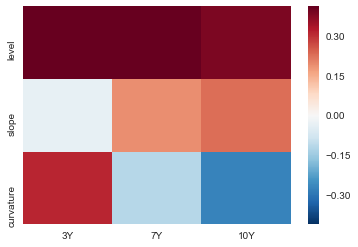

In [12]:
comps = pd.DataFrame(f[0:3,[4,6,7]], columns = ['3Y','7Y','10Y'])#,rows = ['level','slope','curvature'])
comps = comps.set_index([['level','slope','curvature']])
#comps = comps.T
#comps.rename(columns = {'level','slope','curvature'})
print(comps)
sn.heatmap(comps)

c. Compute weights of the WFLY to make sure that WFLY does not have PCA1,2 risk exposure in Sample1.
Let’s call this combination WFLY1

In [13]:
##let 2 partical derivatives = 0
formula1 = [ comps.loc['level','3Y'],comps.loc['level','10Y'] ]
formula2 = [ comps.loc['slope','3Y'],comps.loc['slope','10Y'] ]
a = np.array([formula1, formula2])
response = [ comps.loc['level','7Y'],comps.loc['slope','7Y'] ]
b = np.array(response)
WFLY1 = np.linalg.solve(a, b)   #Computes the “exact” solution, x, of linear matrix equation ax = b
print('weights via PCA method: ', WFLY1)

#if use df1 as dataset, array([ 0.23723845,  0.83191551])

weights via PCA method:  [ 0.1988371   0.85563356]


d. Choose weights of the WFLY from cointegration analysis (weights correspond to the best cointegrated vector). 
Let’s call this combination WFLY2
i. Use Box-Tiao or Chou-Ng estimation procedures 

Here I use CCA by Box-Tiao.

Refer to the paper P363, the differenced series cannot be put into AR(1), so I use original data.

It finds linear combinations of variables ranked in order of predictability by computing eigenvectors of Q (the matrix measure of predictibility). 
The bigger eigenvalues mean better predictibility while smaller eigenvalues have worse. 
Bad predictibility depends less on the past, which means more stationary.

I find the eigenvector corresponding to least eigenvalue of Q, 
least predicitable - stationary and independent - reflect relationships which remains stable over the time.

In [14]:
df_Box = df1.loc[:,['3 Yr','7 Yr','10 Yr']]
mu = df_Box.mean()
##remove mean, get stationary series
df_B = df_Box - mu 
data_set1 = df_B.iloc[:-1,:]
data_set2 = df_B.iloc[1:,:]
#data_set1 = df_Box
#data_set2 = data_set1.shift(1).dropna()#shift forward by one period--- wrong
#or use formula(6) in mean revert paper: phiT = np.dot(np.dot(np.linalg.inv(np.dot(data_set1.T,data_set1)),data_set1.T),data_set2)
phiT = np.linalg.lstsq(data_set1, data_set2)[0] # least-squares solution to a linear matrix equation data_set2 = data_set1*phiT
#print("phi",phiT)
covz = data_set1.cov()
##predictible measure Q
#Q = np.dot( np.dot( np.dot(np.linalg.inv(covz), phiT.T), covz), phiT)
Q = np.dot(np.linalg.inv(covz), np.dot(phiT.T,np.dot(covz,phiT)))
val, vec = np.linalg.eig(Q)
print(val, vec)
eigi_pairs = [(val[i], vec[:,i]) for i in range(len(val))]
eigi_pairs.sort(key=lambda x: x[0],reverse=False) #sort the eigenvalue from tuples from low to high
##find the eigenvecotr to the least eigenvalue as weights
weight = eigi_pairs[0][1]
WFLY2 = np.array([-weight[0]/weight[1], -1, -weight[2]/weight[1]])
print('weights via CCA method - Box Tiao: ', WFLY2)

[ 0.65714382  0.9973796   0.95649773] [[ 0.17850857 -0.71091204 -0.26957127]
 [-0.7543349  -0.08153914  0.93572689]
 [ 0.63175435  0.69853807  0.2274786 ]]
weights via CCA method - Box Tiao:  [ 0.23664365 -1.          0.83749851]


From the section above, we can see that weights calculated by PCA, CCA (Box & Tiao) are very similar.

3. Compute Half-Life & ADF statistic for FLY, WFLY1, WFLY2 using Sample1, compare results
a. Note that you are considering time series of levels, not daily differences

ADF tests:
The Augmented Dickey Fuller Test (ADF) is unit root test for stationarity. 
Unit roots can cause unpredictable results in your time series analysis. 
If all the unit roots are outside unit circle, the time series is stationary; otherwise not.

Half-life of mean reversion gives the slowness of a mean-reversion process. Details: http://marcoagd.usuarios.rdc.puc-rio.br/half-life.html

In [19]:
#'statsmodels' to perform ADF test and OLS regression
import statsmodels.tsa.stattools as tsa 
import statsmodels.api as sm 

# define a function: stationary test for each portfolio
def stationary_test(data):
    # compute ADF test statistic
    adf_ = tsa.adfuller(data)
    print('adf', adf_[0])
    print('p-value', adf_[1])

    #perform Half life
    data_lag = data.shift(1)
    Y = data[1:] - data_lag[1:]
    X = sm.add_constant(data_lag[1:])  #Adds a column of ones to an array
    model = sm.OLS(Y, X)
    res = model.fit()
    halflife = round(-np.log(2) / res.params[1], 0)  #E[dx] = h (m - x) dt, res.params[1] is h, dt = 1
    print('Halflife = ', halflife)
    #return adf_, halflife


In [20]:
# calculate portfolio on sample1
df = df.loc[:,['3 Yr','7 Yr','10 Yr']]
df1 = df[d1:d2]
data_FLY = 0.5 * df1.loc[:, '3 Yr'] - df1.loc[:, '7 Yr'] + 0.5 * df1.loc[:, '10 Yr']
#df1.loc['FLY'] = 0.5 * df1.loc[:, '3 Yr'] - df1.loc[:, '7 Yr'] + 0.5 * df1.loc[:, '10 Yr']
data_WFLY1 = WFLY1[0] * df1.loc[:, '3 Yr'] - df1.loc[:, '7 Yr'] + WFLY1[1] * df1.loc[:, '10 Yr']
data_WFLY2 = WFLY2[0] * df1.loc[:, '3 Yr'] - df1.loc[:, '7 Yr'] + WFLY2[1] * df1.loc[:, '10 Yr']

#call the function stationary_test()
print('FLY:')
test_FLY = stationary_test(data_FLY)
print('\nWFLY1:')
test_WFLY1 = stationary_test(data_WFLY1)
print('\nWFLY2:')
test_WFLY2 = stationary_test(data_WFLY2)

FLY:
adf -1.09424566268
p-value 0.717361204362
Halflife =  216.0

WFLY1:
adf -2.73113936472
p-value 0.0688030559463
Halflife =  12.0

WFLY2:
adf -2.23218373021
p-value 0.194772616204
Halflife =  32.0


Compare:
The FLY on training samples are far from stationary (p-value 0.7) and have more than 200 days to go back to the mean. This portfolio is not good for a short-term trader.
The PCA FLY on training sample(sample1) is stationary (p-value=0.0688), and this means that the first two components explains sample1 well.
The stationary ability of CCA FLY on training samples are not so clear as p value is 0.19.
The halflife of WFLY1 and WFLY2 are small, so the 2 models are relatively good in this sense. 

4. Repeat Step #3 out-of-sample: using 3m, 6m, 12m, 24m out of sample periods
a. How do out-of-sample results compare across periods and combinations?

In [55]:
# predict portfolio on out of sample 3M
dftemp = df['02/01/2006':'04/30/2006']
data_FLY = 0.5 * dftemp.loc[:, '3 Yr'] - dftemp.loc[:, '7 Yr'] + 0.5 * dftemp.loc[:, '10 Yr']
data_WFLY1 = WFLY1[0] * dftemp.loc[:, '3 Yr'] - dftemp.loc[:, '7 Yr'] + WFLY1[1] * dftemp.loc[:, '10 Yr']
data_WFLY2 = WFLY2[0] * dftemp.loc[:, '3 Yr'] - dftemp.loc[:, '7 Yr'] + WFLY2[1] * dftemp.loc[:, '10 Yr']

print('3M sample:\n')
print('FLY:')
stationary_test(data_FLY)
print('\nWFLY1:')
stationary_test(data_WFLY1)
print('\nWFLY2:')
stationary_test(data_WFLY2)


3M sample:

FLY:
adf -0.46881063157
p-value 0.897960535503
Halflife =  8.0

WFLY1:
adf -0.844872800471
p-value 0.805584497929
Halflife =  15.0

WFLY2:
adf 1.59911516462
p-value 0.997854918765
Halflife =  62.0


In [56]:
# predict portfolio on out of sample 6M
dftemp = df['02/01/2006':'07/31/2006']
data_FLY = 0.5 * dftemp.loc[:, '3 Yr'] - dftemp.loc[:, '7 Yr'] + 0.5 * dftemp.loc[:, '10 Yr']
data_WFLY1 = WFLY1[0] * dftemp.loc[:, '3 Yr'] - dftemp.loc[:, '7 Yr'] + WFLY1[1] * dftemp.loc[:, '10 Yr']
data_WFLY2 = WFLY2[0] * dftemp.loc[:, '3 Yr'] - dftemp.loc[:, '7 Yr'] + WFLY2[1] * dftemp.loc[:, '10 Yr']
print('6M sample:\n')
print('FLY:')
stationary_test(data_FLY)
print('\nWFLY1:')
stationary_test(data_WFLY1)
print('\nWFLY2:')
stationary_test(data_WFLY2)

6M sample:

FLY:
adf -1.57436309028
p-value 0.496457676389
Halflife =  4.0

WFLY1:
adf -1.35803560402
p-value 0.602220968884
Halflife =  11.0

WFLY2:
adf -1.76110448962
p-value 0.399935944259
Halflife =  24.0


In [57]:
# predict portfolio on out of sample 12M
dftemp = df['02/01/2006':'01/31/2007']
data_FLY = 0.5 * dftemp.loc[:, '3 Yr'] - dftemp.loc[:, '7 Yr'] + 0.5 * dftemp.loc[:, '10 Yr']
data_WFLY1 = WFLY1[0] * dftemp.loc[:, '3 Yr'] - dftemp.loc[:, '7 Yr'] + WFLY1[1] * dftemp.loc[:, '10 Yr']
data_WFLY2 = WFLY2[0] * dftemp.loc[:, '3 Yr'] - dftemp.loc[:, '7 Yr'] + WFLY2[1] * dftemp.loc[:, '10 Yr']
print('12M sample:\n')
print('FLY:')
stationary_test(data_FLY)
print('\nWFLY1:')
stationary_test(data_WFLY1)
print('\nWFLY2:')
stationary_test(data_WFLY2)


12M sample:

FLY:
adf -2.50570455532
p-value 0.11409250744
Halflife =  4.0

WFLY1:
adf -1.81627412952
p-value 0.372412495653
Halflife =  10.0

WFLY2:
adf -1.71620101965
p-value 0.422785147851
Halflife =  35.0


In [58]:
# predict portfolio on out of sample 12M
dftemp = df['02/01/2006':'01/31/2008']
data_FLY = 0.5 * dftemp.loc[:, '3 Yr'] - dftemp.loc[:, '7 Yr'] + 0.5 * dftemp.loc[:, '10 Yr']
data_WFLY1 = WFLY1[0] * dftemp.loc[:, '3 Yr'] - dftemp.loc[:, '7 Yr'] + WFLY1[1] * dftemp.loc[:, '10 Yr']
data_WFLY2 = WFLY2[0] * dftemp.loc[:, '3 Yr'] - dftemp.loc[:, '7 Yr'] + WFLY2[1] * dftemp.loc[:, '10 Yr']
print('24M sample:\n')
print('FLY:')
stationary_test(data_FLY)
print('\nWFLY1:')
stationary_test(data_WFLY1)
print('\nWFLY2:')
stationary_test(data_WFLY2)

24M sample:

FLY:
adf 1.74239455697
p-value 0.998227653688
Halflife =  -313.0

WFLY1:
adf -0.78555390952
p-value 0.823328711405
Halflife =  28.0

WFLY2:
adf -0.13836446883
p-value 0.945480661859
Halflife =  785.0


Stationarity:
The original FLY on the test sampls have big p values(most of them are above 0.6), so FLY are far from stationary.

Although the PCA FLY on traning samples are stationary, PCA FLY on test samples are ill-behaved (most of p-values are above 0.6). So, PCA FLY is not stable.

For FLY CCA, it should be most stationary, but here I did not see any stationary properties.

Half life:
For most of the case, CCA FLY > PCA FLY > FLY.

Across the periods:
From the results of adf test, the portfolios are more stationary in 12M, and perform terribly in 24M.


## Q5
Read d’Aspremont’s paper: Identifying Small Mean-Reverting Portfolios
a. Explain the rationale for sparse decomposition algorithms
b. Describe & compare results in Figures 1 and 6


## The rationale for sparse decomposition algorithms:

We want to solve the target(1):

$$ maxmize   \space  \space { x^TAx \over x^TBx }  $$
$$ subject\space to  \space {Card(x)≤k \space \space ||x|| = 1}$$

where k is a given constant and Card(x) is the number of nonzero coefficients in x. This will compute a sparse portfolio with maximum predicitibility.

### Greedy Search

This algorithm does recursively. Suppose we have a good prroximate solution with support set  $I_{k}$. We add a variable with index  $I_{k+1}$ to set $I_{k}$ to produce the largest increase in predictability in  $I_{k}^{c}$. Then we repeat this process until k=n.

### Semidefinite Relaxation

We drop nonconvex constraint $Card(X) ≤ k^{2}$ and then rewrite the target(1) as the following: 

$$maximize \space \space {Tr(AY)} $$
 
 $$subject\space to \space \space {1^{T}|Y|1 − kz ≤ 0}$$
 
 $$Tr(Y) − z = 0$$
 
 $$Tr(BY ) = 1$$
 
$$Y >= 0$$
Which is a semidefinite program(SDP) in the variables Y∈$S_n$ and z∈$R_+$ and can be solved using standard SDP solvers.

### Comparison

The computational complexity of greedy search is smaller than semidefinite relaxation. But the solution of greedy search is far from optimal while the performance of the solutions produced by semidefinite relaxation is often higher.

### Description 
Figure 1 describes Box-Tiao decomposition on 100 days of US swap rate data. The eight canonical portfolios of swap rates with maturities ranging from one to thirty yearsare ranked in decreasing order of predictability. The mean reversion coefficient λ. 

Figure 2 describes Sparse canonical decomposition on 100 days of U.S. swap rates data. The eight canonical portfolios of swap rates with the mean reversion coefficient λ and number of nonzero coefficients in each portfolio vector k.  

### Comparsion
The distriution of k in Figure2 is more dense than in Figure1. Like the last 2 graphs in Figure2, mean reversion coefficients λ are same as 252. 
In addition, we could see the mean reversion become more obvious in Figure2 than Figure1 when k is bigger. So, the property of mean reversion using sparse decomposition converges more quickly than using Box-Tian. From my perspective, with a given k, the portfolio constructed by sparse decomposition might have less contraints, so, the portfolio might have less predictability. In practice, sparse decompostion is easier for us to find a mean reversion trading strategy than Box-Tiao. But we need to compare the results when the 2 algos are appied on out of sample.